* To check my four days mean current without Coriolis force.

In [1]:
%matplotlib inline
from IPython.core.display import Image,display
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io as sio
import datetime
from salishsea_tools import (viz_tools,tidetools,nc_tools,stormtools)
import matplotlib.gridspec as gridspec
import numpy.ma as ma
import os
import glob
import codar

In [2]:
## load different bathys
grid2 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc')
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X={};Y={};bathy={};grids = [grid2,grid6]
for grid in grids:
    X[grid] = grid.variables['nav_lon'][:, :]
    Y[grid] = grid.variables['nav_lat'][:, :]
    bathy[grid] = grid.variables['Bathymetry'][:, :]

In [3]:
uv_all = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/TestF4days/codar_testF.nc')

In [4]:
#subset
ist=1
ien=398
jst=1
jen=898
x=np.arange(ist,ien)
y=np.arange(jst,jen)
st = 3

In [5]:
def plot(cmin=0, cmax = 0.5,lonmax =-123, lonmin =-123.7, latmax =49.15, latmin = 49 ):
    
    u_6 = uv_all.variables['vozocrtx']
    v_6 = uv_all.variables['vomecrty']
    u_mean6 = np.nanmean(u_6, axis = 0)
    v_mean6 = np.nanmean(v_6, axis = 0)
    
    u_m = {};v_m = {}; U_m = {};V_m = {};lon = {};lat ={} 
    u_m[grid6] =u_mean6[0,:,:]
    v_m[grid6] =v_mean6[0,:,:]
    ##unstagger u v
    U_m[grid6],V_m[grid6] = viz_tools.unstagger(u_m[grid6],v_m[grid6])
    #rotate
    theta = np.pi*29/180
    U_m[grid6] = U_m[grid6]*np.cos(theta) - V_m[grid6]*np.sin(theta)
    V_m[grid6] = U_m[grid6]*np.sin(theta) +V_m[grid6]*np.cos(theta)
    ##mask
    U_m[grid6]=np.ma.masked_values(U_m[grid6],0)
    V_m[grid6]=np.ma.masked_values(V_m[grid6],0)

    lon[grid6] = X[grid6][380:479,240:319]
    lat[grid6] = Y[grid6][380:479,240:319]
    
    fig, axs = plt.subplots(1,2,figsize = (15,6))
    mesh=axs[0].pcolormesh(lon[grid6], lat[grid6], \
            np.sqrt(U_m[grid6]**2+V_m[grid6]**2), cmap='Reds', vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(mesh, ax=axs[0])
    cbar.set_label('Total Velocity[m/s]', fontsize = 20)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
    quiver = axs[0].quiver(lon[grid6][::st], lat[grid6][::st], U_m[grid6][::st], V_m[grid6][::st],\
                        pivot='mid',scale=6,width=0.005, color='black')
    axs[0].quiverkey(quiver,-123.1,49.12, 0.5, '0.5 m/s', coordinates='data', color='black', labelcolor='black',\
                fontproperties = {'size': '15'})
    U_m[grid6][:] = 0;
    V_m[grid6][:] = 0;
    quiver = axs[1].quiver(lon[grid6][::st], lat[grid6][::st], U_m[grid6][::st], V_m[grid6][::st],\
                        pivot='mid',scale=5,width=0.005, color='black')
    for ax in [axs[0],axs[1]]:
        viz_tools.plot_land_mask(ax,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
        ax.set_xlim(lonmin,lonmax)
        ax.set_ylim(latmin, latmax)
        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20)
        ax.set_xlabel('Longitude',fontsize=20)
        ax.set_ylabel('Latitude',fontsize=20)
        ax.set_xticks([-123.6, -123.4, -123.2,-123])
        ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
    return fig

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


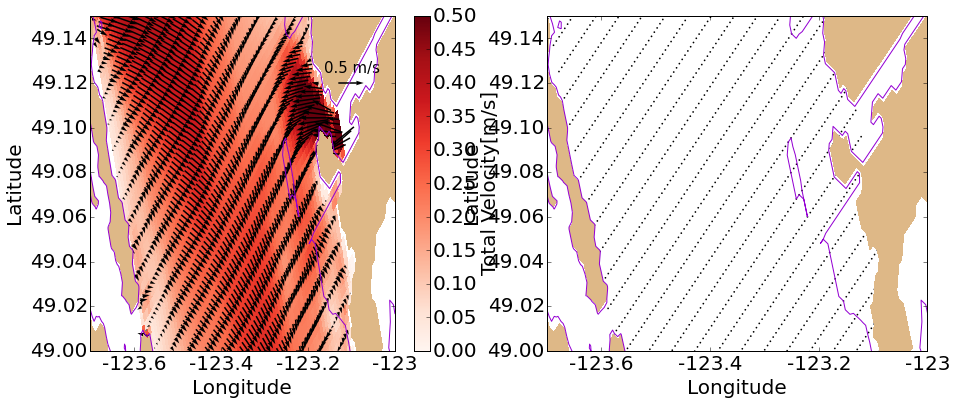

In [6]:
fig = plot()

* Most of the current goes southward except the river mouth region, is that real?? If true, which means even without Coriolis force, still strong northward outflow at the river mouth area. But could be due to southeasternly wind during that four days. Will do a month to see if still exists, or signal reduced.
* Southward velocity maximizes in the central strait, why?? 

# no f for one month

In [7]:
uv = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/OctMeanCurrent/codar_all_large.nc'); 
uv_noF = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/noF/codar_noF.nc')

In [10]:
def plot_all(cmin=0, cmax = 0.3,lonmax =-123., lonmin =-123.7, latmax =49.2, latmin = 49 ):  
    ncs = [uv,uv_noF]
    types = ['f','nof']
    u_m = {};v_m = {}; U_m = {};V_m = {};lon = {};lat ={} 
    fig, axs = plt.subplots(1,3,figsize = (21,6))
    for nc,tp,ax in zip(ncs,types, axs[:2]):
        u_6= nc.variables['vozocrtx']
        v_6 = nc.variables['vomecrty']
        u_mean6 = np.nanmean(u_6, axis = 0)
        v_mean6 = np.nanmean(v_6, axis = 0)

        u_m[tp] =u_mean6[0,:,:]
        v_m[tp] =v_mean6[0,:,:]
        ##unstagger u v
        U_m[tp],V_m[tp] = viz_tools.unstagger(u_m[tp],v_m[tp])
        #rotate
        theta = np.pi*29/180
        U_m[tp] = U_m[tp]*np.cos(theta) - V_m[tp]*np.sin(theta)
        V_m[tp] = U_m[tp]*np.sin(theta) +V_m[tp]*np.cos(theta)
        ##mask
        U_m[tp]=np.ma.masked_values(U_m[tp],0)
        V_m[tp]=np.ma.masked_values(V_m[tp],0)
        lon[tp] = X[grid6][380:479,240:319]
        lat[tp] = Y[grid6][380:479,240:319]

        mesh=ax.pcolormesh(lon[tp], lat[tp],np.sqrt(U_m[tp]**2+V_m[tp]**2), cmap='Reds', vmin=cmin, vmax=cmax)
        cbar = plt.colorbar(mesh, ax=ax)
        cbar.set_label('Total Velocity[m/s]', fontsize = 20)
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
        quiver = ax.quiver(lon[tp][::st], lat[tp][::st], U_m[tp][::st], V_m[tp][::st],\
                            pivot='mid',scale=2.5,width=0.005, color='black')
        ax.quiverkey(quiver,-123.1,49.15, 0.1, '0.1 m/s', coordinates='data', color='black', labelcolor='black',\
                                    fontproperties = {'size': '15'})
        viz_tools.plot_land_mask(ax,grid6,coords='map',xslice=x,yslice=y,color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
        ax.set_title(tp)
    ##diff
    mesh=axs[2].pcolormesh(lon[types[1]], lat[types[1]],\
                           np.sqrt(U_m[types[1]]**2+V_m[types[1]]**2) -np.sqrt(U_m[types[0]]**2+V_m[types[0]]**2) , \
                           cmap='bwr', vmin=-0.1, vmax=0.1)
    cbar = plt.colorbar(mesh, ax=axs[2])
    cbar.set_label('Total Velocity[m/s]', fontsize = 20)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
    quiver = axs[2].quiver(lon[types[1]][::st], lat[types[1]][::st], U_m[types[1]][::st]-U_m[types[1]][::st],\
                       V_m[types[0]][::st]-V_m[types[0]][::st],pivot='mid',scale=2.5,width=0.005, color='black')
    axs[2].quiverkey(quiver,-123.1,49.15, 0.1, '0.1 m/s', coordinates='data', color='black', labelcolor='black',\
                                    fontproperties = {'size': '15'})
    axs[2].set_title('nof - f')
    viz_tools.plot_land_mask(axs[2],grid6,coords='map',xslice=x,yslice=y,color='burlywood')
    viz_tools.plot_coastline(axs[2], grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
    for ax in axs:
        ax.set_xlim(lonmin,lonmax)
        ax.set_ylim(latmin, latmax)     
        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20)
        ax.set_xlabel('Longitude',fontsize=20)
        ax.set_ylabel('Latitude',fontsize=20)
        ax.set_xticks([-123.6, -123.4, -123.2,-123])
        ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
    
    return fig

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


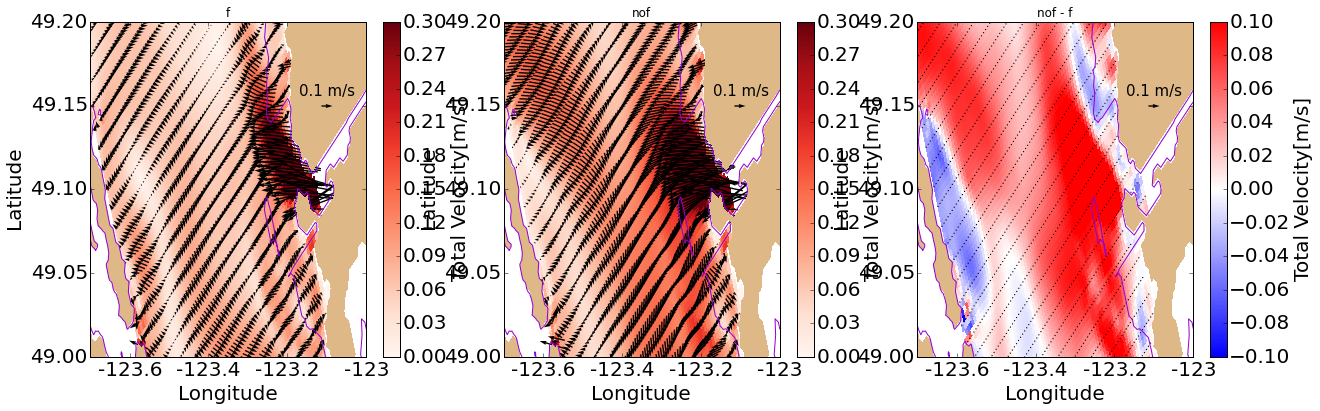

In [11]:
fig = plot_all()